# Introduction

Let's double check that we get reasonable spike-in values when using a more correct insert size and standard deviation.

In [1]:
import pandas
import seaborn
import scipy
import os
import sys
from pathlib import Path
from matplotlib import pyplot, cm, colors
import numpy

In [2]:
LRS = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRS not in sys.path:
    sys.path.append(LRS)
from woldrnaseq import models, madqc

In [3]:
root = Path('~/proj/analysis/hff_kallisto').expanduser()

In [4]:
libraries = models.load_library_tables([root / 'libraries.tsv'])
experiments = models.load_experiments([root / 'experiments.tsv'])

Unrecognized columns present. Is this intended?: fragment_length,fragment_length_cv


In [5]:
experiments

replicates  \
experiment                                                                                       
Clonal line 6 derived from hTert immortalized HFF                        [21515, 21516, 21517]   
Clonal line 6 derived from hTert immortalized H...                       [22109, 22110, 22111]   
Clonal line 6 derived from hTert immortalized H...                              [22112, 22113]   
Clonal line 6 derived from hTert immortalized H...  [22145, 22146, 22147, 22154, 22155, 22156]   
Clonal line 6 derived from hTert immortalized H...  [22148, 22149, 22150, 22157, 22158, 22159]   
Clonal line 6 derived from hTert immortalized H...  [22151, 22152, 22153, 22160, 22161, 22162]   

                                                                                         analysis_dir  
experiment                                                                                             
Clonal line 6 derived from hTert immortalized HFF   /woldlab/loxcyc/home/diane/proj/analysis/hff_k...  
Clonal line 6 derived from hTert immortalized H...  /woldlab/loxcyc/home/diane/proj/analysis/hff_k...  
Clonal line 6 derived from hTert immortalized H...  /woldlab/loxcyc/home/diane/proj/analysis/hff_k...  
Clonal line 6 derived from hTert immortalized H...  /woldlab/loxcyc/home/diane/proj/analysis/hff_k...  
Clonal line 6 derived from hTert immortalized H...  /woldlab/loxcyc/home/diane/proj/analysis/hff_k...  
Clonal line 6 derived from hTert immortalized H...  /woldlab/loxcyc/home/diane/proj/analysis/hff_k...

In [6]:
# 22152, 22113 are still running
# Use "Clonal line 6 derived from hTert immortalized HFF 600 ng starting amount" to start


In [7]:
def load_kallisto_transcript_abunduance(filename):
    def identity(x):
        return x
    def convert_transcript_id(x):
        if x.startswith('ERCC'):
            return 'tSpikein_' + x
        elif x == 'phiX174':
            return 'tSpikein_phiX174'
        else:
            return x
    records = []
    header = ['transcript_id', 'gene_id', 'transcript_name', 'transcript_type']
    target_fields = [0, 1, 4, 7]
    target_converters = [convert_transcript_id, identity, identity, identity]
    field_converters = [identity, int, float, float, float]
    with open(filename, 'rt') as instream:
        abundance_header = instream.readline()
        abundance_header = abundance_header.strip().split('\t')
        header.extend(abundance_header[1:])
        for line in instream:
            fields = line.rstrip().split('\t')
            targets = fields[0].split('|')
            row = []
            for i, converter in zip(target_fields, target_converters):
                if len(targets) > i:
                    row.append(converter(targets[i]))
                else:
                    row.append(None)
            for i, converter in enumerate(field_converters[1:]):
                row.append(converter(fields[i+1]))
            records.append(row)
    df = pandas.DataFrame(records, columns=header)
    return df.set_index('transcript_id')

def load_kallisto_quantifications(experiment_files, index=None, column='tpm'):
    quantifications = []
    filenames = []
    for filename in experiment_files:
        table = load_kallisto_transcript_abunduance(filename)
        table = table[[column]]

        quantifications.append(table[column])
        _, name = os.path.split(filename)
        filenames.append(name)

    df = pandas.concat(quantifications, axis=1)
    if index:
        df.columns = index
    else:
        df.columns = filenames
    return df

def load_kallisto_replicates(experiment, libraries, column):
    analysis_files = []
    library_ids = []

    assert isinstance(experiment, pandas.Series)
    for library_id in experiment.replicates:
        library_ids.append(library_id)
        library = libraries.loc[library_id]
        analysis_dir = Path(library.analysis_dir).expanduser()
        abundance = analysis_dir / 'abundance.tsv'
        if not abundance.exists():
            raise RuntimeError("{} doesn't exist".format(result[0]))
        else:
            analysis_files.append(abundance)
    quantifications = load_kallisto_quantifications(
        analysis_files, index=library_ids, column=column
    )
    return quantifications



In [8]:
def load_salmon_transcript_abunduance(filename):
    table = pandas.read_csv(filename, sep='\t')
    return table.set_index('Name')

def load_salmon_quantifications(experiment_files, index=None, column='TPM'):
    quantifications = []
    filenames = []
    for filename in experiment_files:
        table = load_salmon_transcript_abunduance(filename)
        table = table[[column]]

        quantifications.append(table[column])
        _, name = os.path.split(filename)
        filenames.append(name)

    df = pandas.concat(quantifications, axis=1)
    if index:
        df.columns = index
    else:
        df.columns = filenames
    return df

def load_salmon_replicates(experiment, libraries, column):
    analysis_files = []
    library_ids = []

    assert isinstance(experiment, pandas.Series)
    for library_id in experiment.replicates:
        library_ids.append(library_id)
        library = libraries.loc[library_id]
        analysis_dir = Path(library.analysis_dir).expanduser()
        abundance = analysis_dir / 'salmon' / 'quant.sf'
        if not abundance.exists():
            raise RuntimeError("{} doesn't exist".format(result[0]))
        else:
            analysis_files.append(abundance)
    quantifications = load_salmon_quantifications(
        analysis_files, index=library_ids, column=column
    )
    return quantifications



In [9]:
a = load_kallisto_transcript_abunduance(root / '22148/abundance.tsv')

In [10]:
a

gene_id  transcript_name  \
transcript_id                                             
ENST00000456328.2    ENSG00000223972.5      DDX11L1-202   
ENST00000450305.2    ENSG00000223972.5      DDX11L1-201   
ENST00000488147.1    ENSG00000227232.5       WASH7P-201   
ENST00000619216.1    ENSG00000278267.1    MIR6859-1-201   
ENST00000473358.1    ENSG00000243485.5  MIR1302-2HG-202   
...                                ...              ...   
tSpikein_ERCC-00165               None             None   
tSpikein_ERCC-00168               None             None   
tSpikein_ERCC-00170               None             None   
tSpikein_ERCC-00171               None             None   
tSpikein_phiX174                  None             None   

                                        transcript_type  length  eff_length  \
transcript_id                                                                 
ENST00000456328.2                  processed_transcript    1657   1409.7700   
ENST00000450305.2    transcribed_unprocessed_pseudogene     632    385.0050   
ENST00000488147.1                unprocessed_pseudogene    1351   1103.7700   
ENST00000619216.1                                 miRNA      68     29.3826   
ENST00000473358.1                               lincRNA     712    464.7940   
...                                                 ...     ...         ...   
tSpikein_ERCC-00165                                None     872    624.7730   
tSpikein_ERCC-00168                                None    1024    776.7730   
tSpikein_ERCC-00170                                None    1023    775.7730   
tSpikein_ERCC-00171                                None     505    262.0390   
tSpikein_phiX174                                   None    5386   5138.7700   

                      est_counts         tpm  
transcript_id                                 
ENST00000456328.2       0.706185    0.012108  
ENST00000450305.2       0.000000    0.000000  
ENST00000488147.1      58.187900    1.274210  
ENST00000619216.1       0.000000    0.000000  
ENST00000473358.1       0.000000    0.000000  
...                          ...         ...  
tSpikein_ERCC-00165   174.000000    6.731560  
tSpikein_ERCC-00168     3.000000    0.093350  
tSpikein_ERCC-00170    80.000000    2.492550  
tSpikein_ERCC-00171  5881.000000  542.468000  
tSpikein_phiX174      313.000000    1.472220  

[206791 rows x 7 columns]

In [11]:
b = madqc.load_rsem_quantifications(
    [root / '22148/22148-GRCh38-V29-male_anno_rsem.isoforms.results'],
    index=['22148'],
    column='TPM',
)

In [12]:
def replicate_scatter(left, left_name, right, right_name, cell_id='', column='TPM', threshold=0.8, ax=None):
    assert column in ['TPM', 'count']
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)

    #kallisto_column = 'tpm' if column == 'TPM' else 'est_counts'
    #rsem_column = 'TPM' if column == 'TPM' else 'expected_count'
    left = left.to_frame()
    right = right.to_frame()
    counts = left.merge(right, left_index=True, right_index=True, how='inner')
    counts.columns = [left_name, right_name]
    
    rel_diff = numpy.abs(counts[left_name]-counts[right_name])/(counts.max(axis=1)+1)
    
    set1 = cm.get_cmap('Set1').colors
    #colors = [{True: set1[0], False: set1[1]}[x] for x in (rel_diff > threshold).values]
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in counts.index]
    
    #counts.plot.scatter(x=cell_id+"_x", y=cell_id+"_y", ax=ax, s=2)
    ax.scatter(counts[left_name], counts[right_name], c=colors, s=2)
    b = 6
    lim = numpy.arange(0.1, counts.max().max(), 0.1)
    lim_up = lim + b
    lim_down = lim -b
    ax.plot(lim, lim, c=set1[2])

    spearman = scipy.stats.spearmanr(counts[left_name][-97:], counts[right_name][-97:])[0]
    gene_count = counts[counts > 0].count().max()
    ax.set_title(f'Cell ID: {cell_id}\nTranscripts: {gene_count}\nSpike Spear: {spearman:.3}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(left_name, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(right_name, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


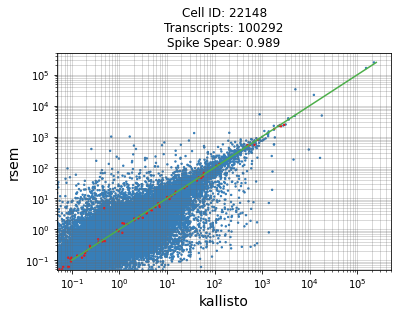

In [13]:
replicate_scatter(a['tpm'], 'kallisto', b['22148'], 'rsem', cell_id='22148', threshold=0.8)

In [14]:
c = load_salmon_transcript_abunduance(root / '22148' / 'salmon' / 'quant.sf')
c.head()

Length  EffectiveLength  TPM  NumReads
Name                                         
10904      93            3.333  0.0       0.0
12954      94            3.355  0.0       0.0
12956      72            2.918  0.0       0.0
12958      82            3.104  0.0       0.0
12960      73            2.935  0.0       0.0

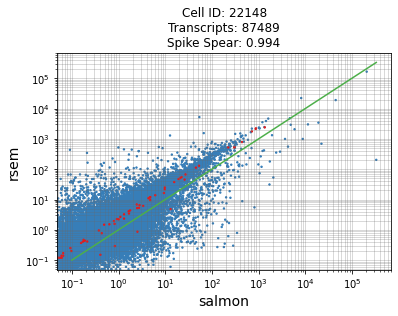

In [15]:
replicate_scatter(c['TPM'], 'salmon', b['22148'], 'rsem', cell_id='22148', threshold=0.8)

In [16]:
def view_scatter_plots_tpm(library_ids):
    for library_id in library_ids:
        a = load_kallisto_transcript_abunduance(root / library_id / 'abundance.tsv')

        rsem_filename = '{}-GRCh38-V29-male_anno_rsem.isoforms.results'.format(library_id)
        b = madqc.load_rsem_quantifications(
            [root / library_id / rsem_filename],
            index=[library_id],
            column='TPM',
        )

        c = load_salmon_transcript_abunduance(root / library_id / 'salmon' / 'quant.sf')

        f = pyplot.figure(figsize=(16,4))
        ax = f.add_subplot(1,3,1)
        replicate_scatter(a['tpm'], 'kallisto', b[library_id], 'rsem', cell_id=library_id, threshold=0.8, ax=ax)
        ax = f.add_subplot(1,3,2)
        replicate_scatter(c['TPM'], 'salmon', b[library_id], 'rsem', cell_id=library_id, threshold=0.8, ax=ax)
        ax = f.add_subplot(1,3,3)
        replicate_scatter(c['TPM'], 'salmon', a['tpm'], 'kallisto', cell_id=library_id, threshold=0.8, ax=ax)


# Clonal line 6 derived from hTert immortalized HFF

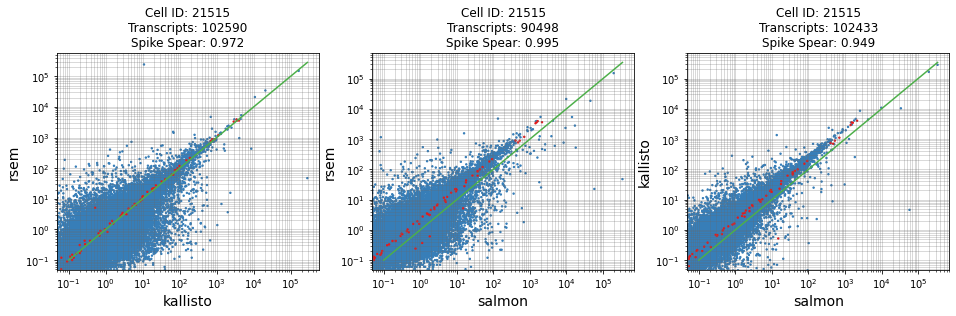

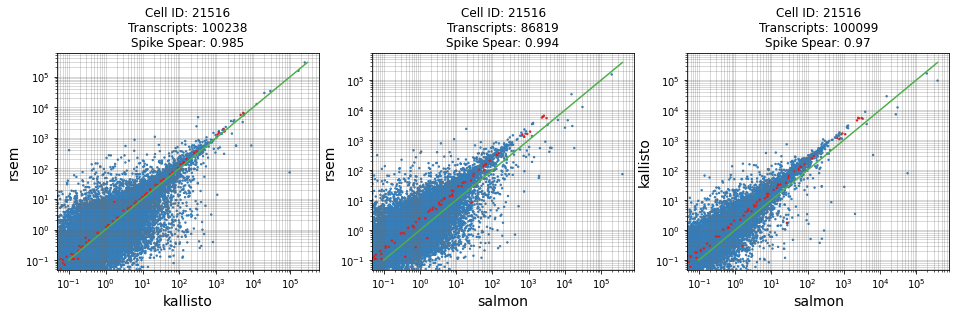

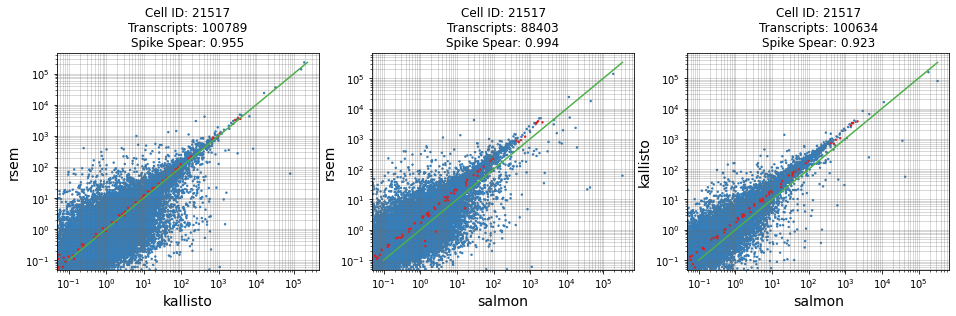

In [17]:
f = view_scatter_plots_tpm(experiments.loc['Clonal line 6 derived from hTert immortalized HFF', "replicates"])

# Clonal line 6 derived from hTert immortalized HFF 13 minute fragmentation

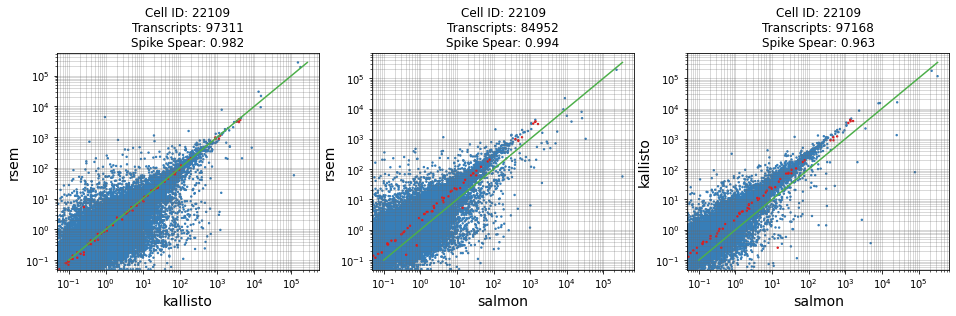

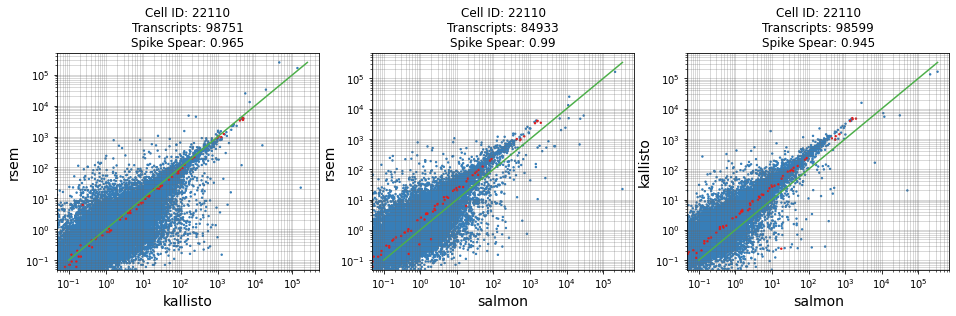

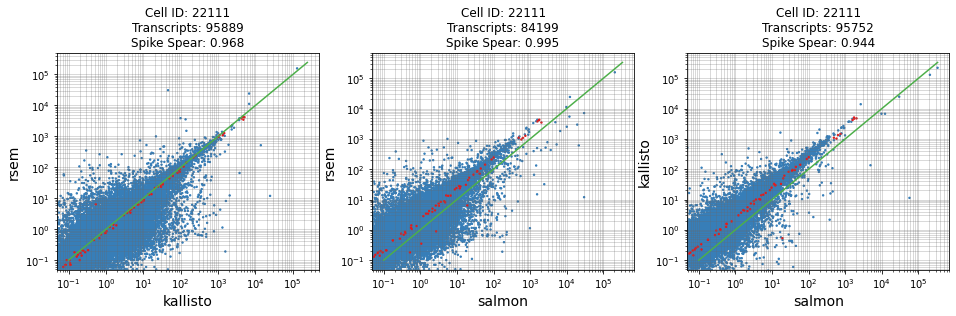

In [18]:
f = view_scatter_plots_tpm(experiments.loc['Clonal line 6 derived from hTert immortalized HFF 13 minute fragmentation', "replicates"])

# Clonal line 6 derived from hTert immortalized HFF 7 minute fragmentation

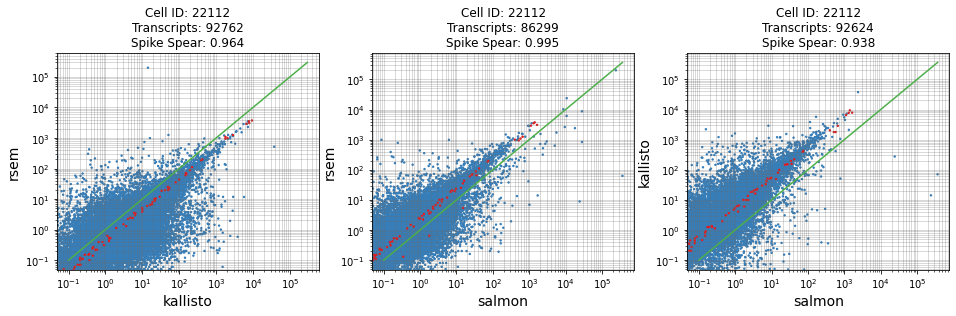

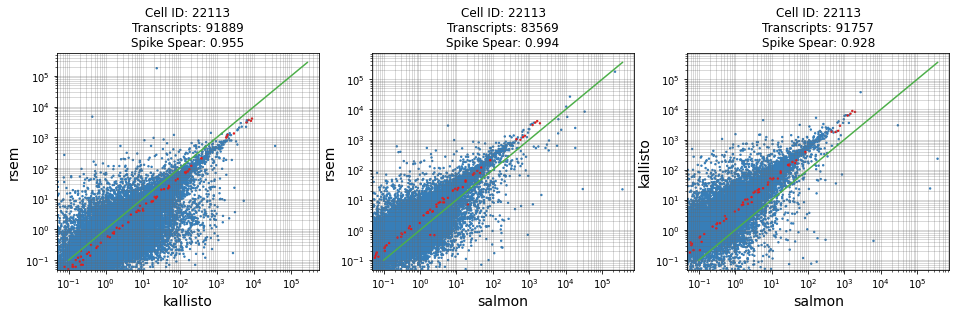

In [19]:
f = view_scatter_plots_tpm(experiments.loc['Clonal line 6 derived from hTert immortalized HFF 7 minute fragmentation', "replicates"])

# Clonal line 6 derived from hTert immortalized HFF 300 ng starting amount

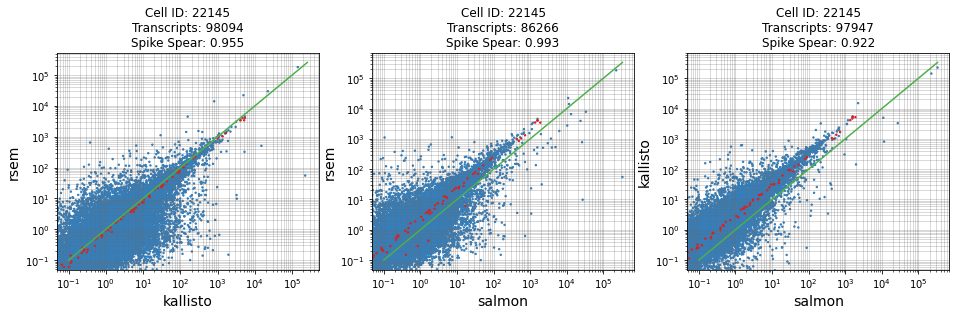

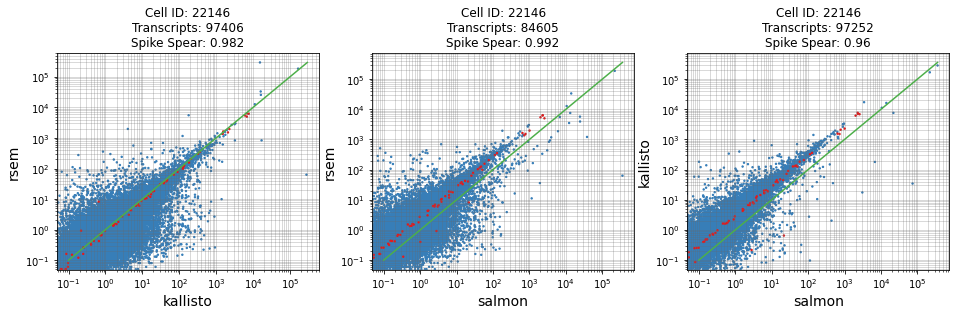

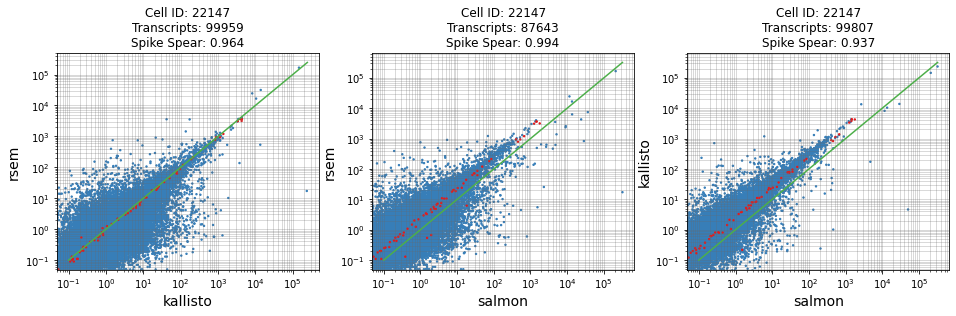

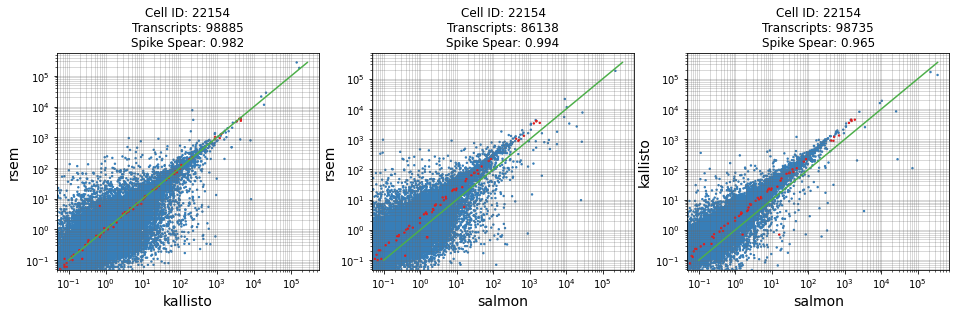

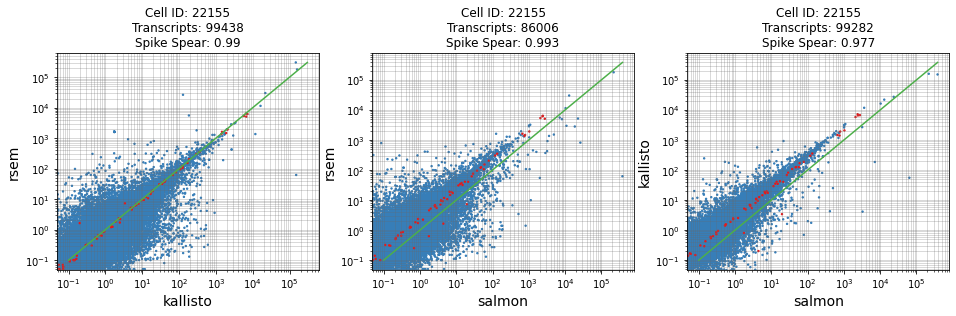

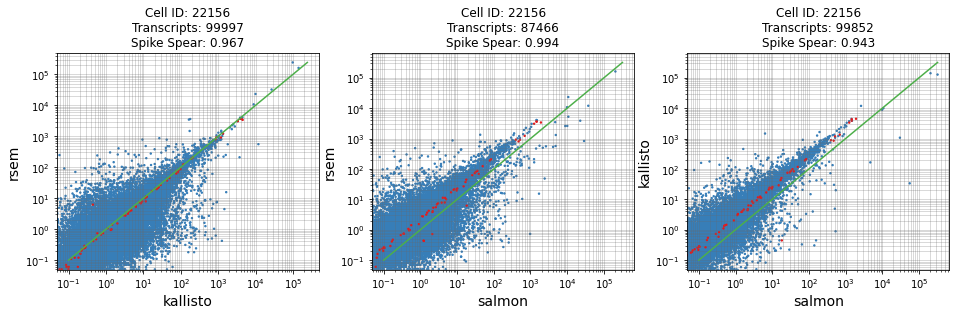

In [20]:
f = view_scatter_plots_tpm(experiments.loc['Clonal line 6 derived from hTert immortalized HFF 300 ng starting amount', "replicates"])

# Clonal line 6 derived from hTert immortalized HFF 600 ng starting amount

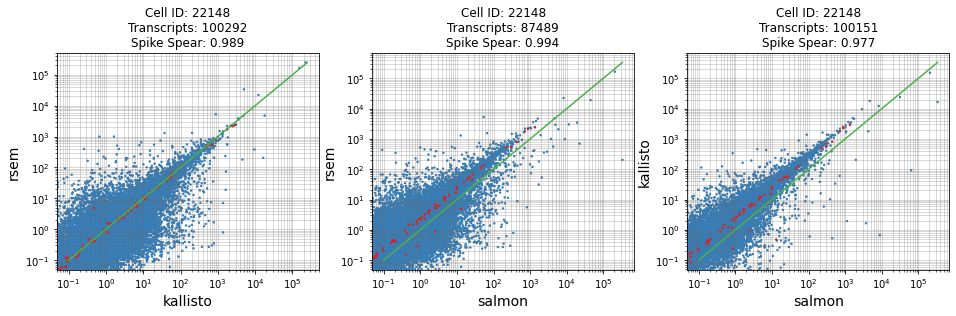

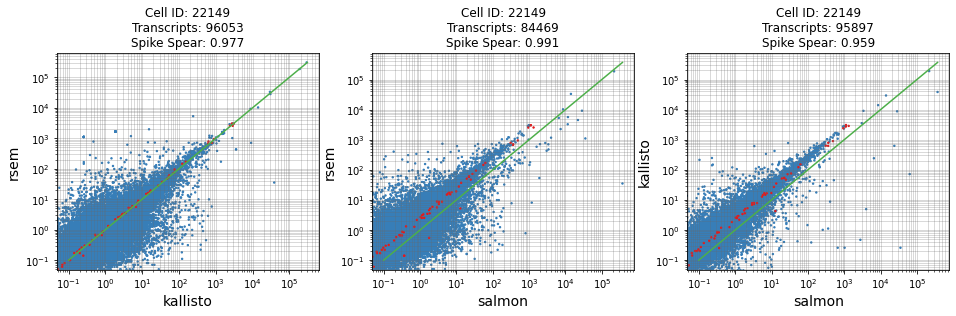

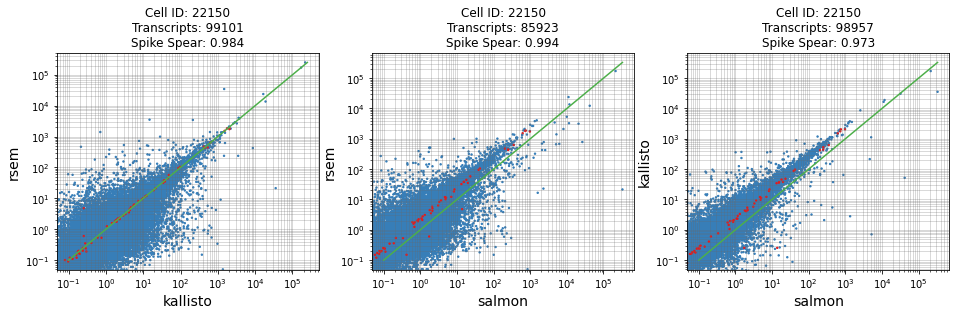

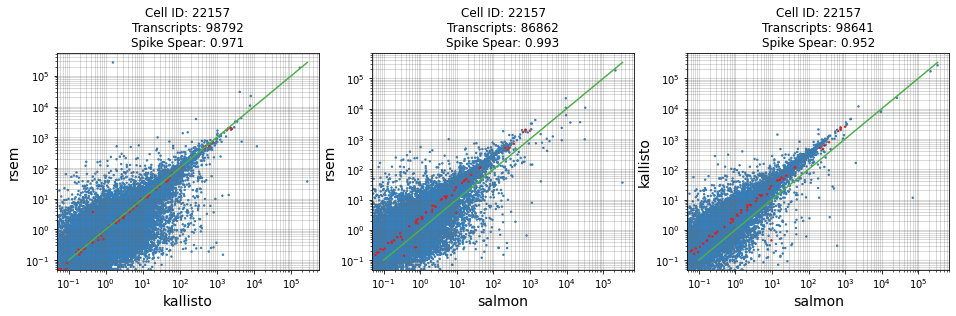

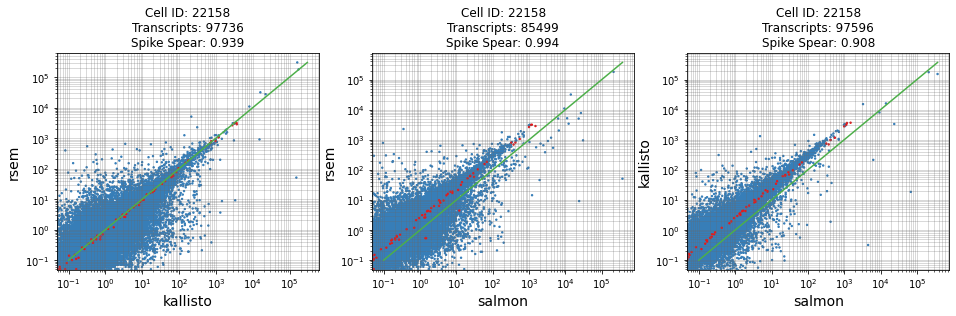

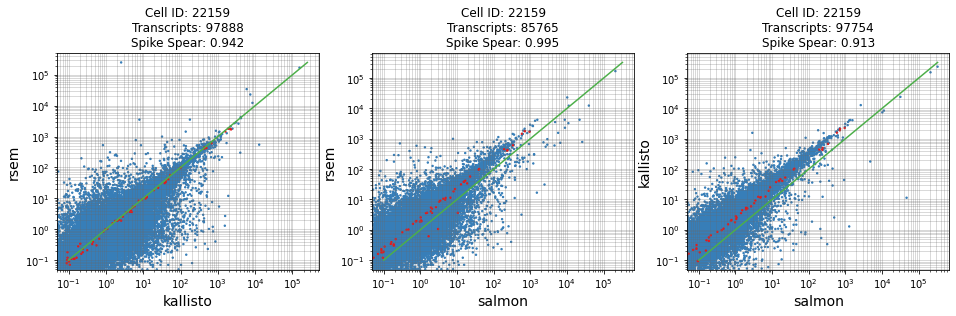

In [21]:
f = view_scatter_plots_tpm(experiments.loc["Clonal line 6 derived from hTert immortalized HFF 600 ng starting amount", "replicates"])

# Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount

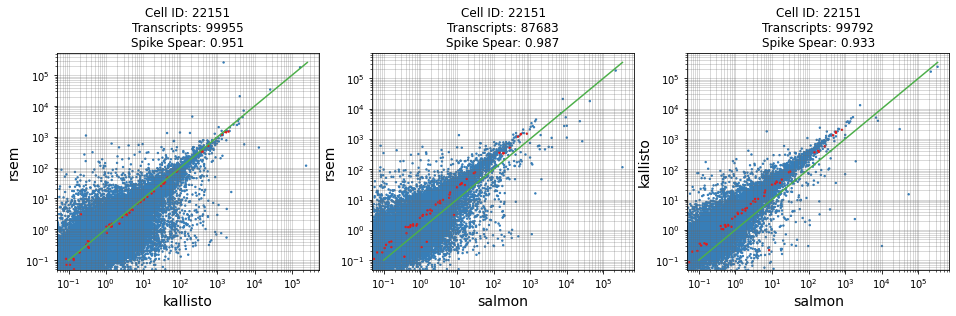

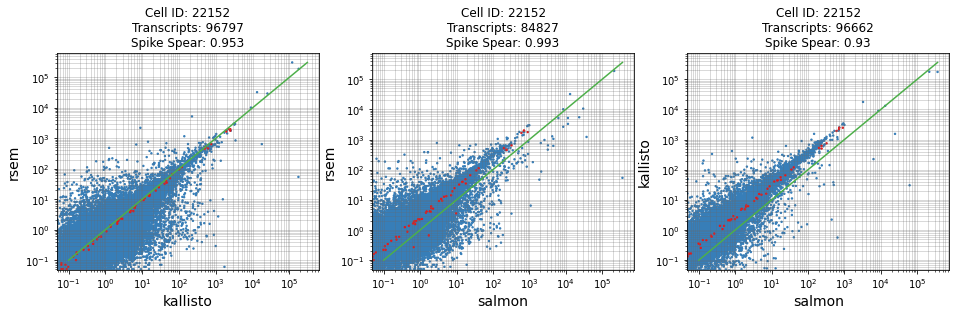

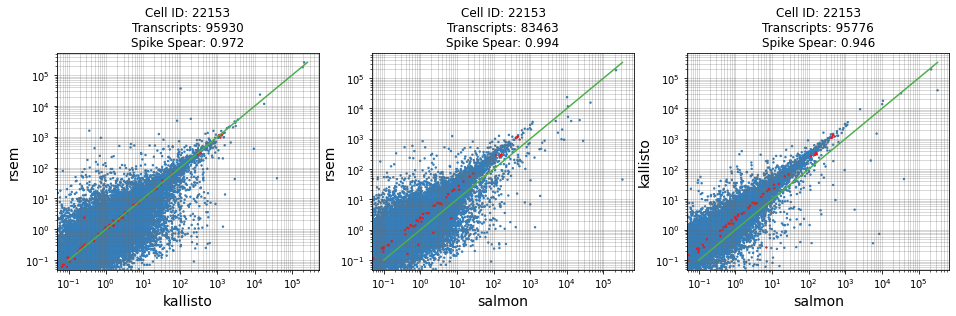

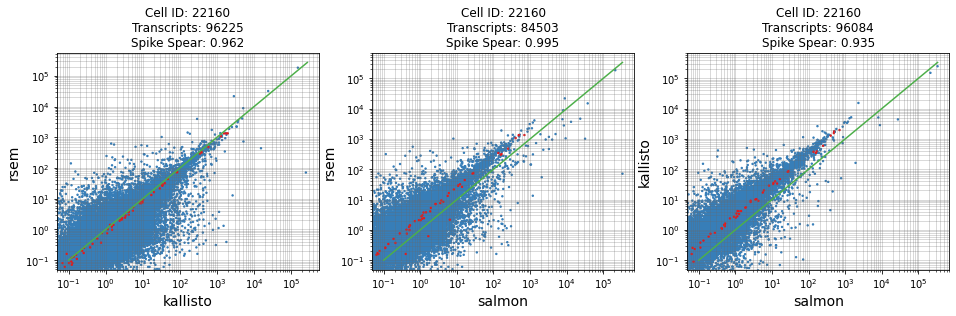

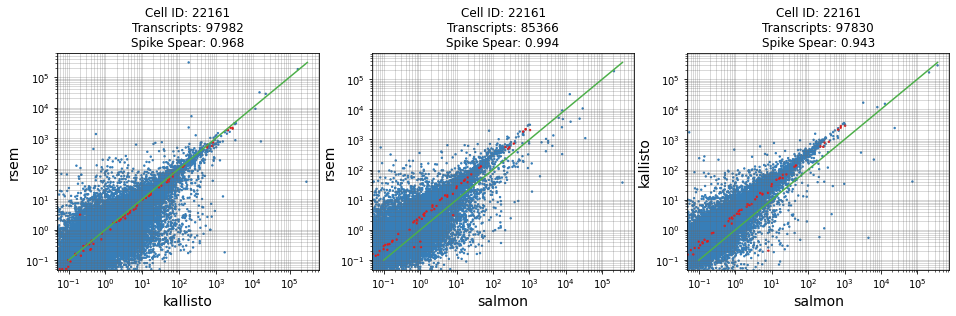

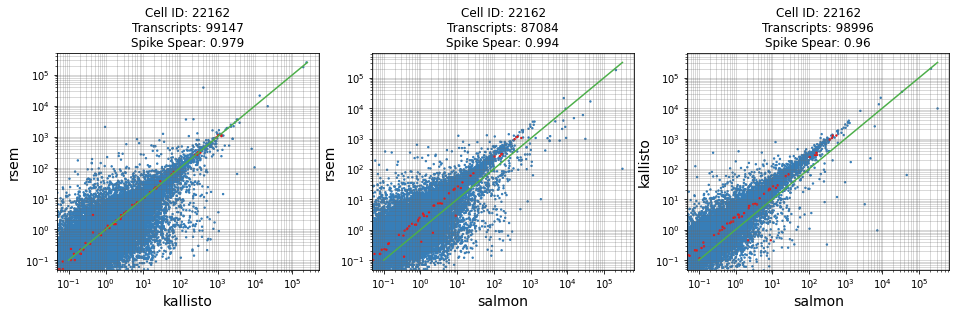

In [22]:
f = view_scatter_plots_tpm(experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount', "replicates"])

In [23]:
hff_900_kallisto_tpm = load_kallisto_replicates(
    experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount'],
    libraries,
    column='tpm'
)
hff_900_kallisto_tpm.head()

22151     22152    22153     22160     22161     22162
transcript_id                                                               
ENST00000456328.2  0.335131  0.224849  0.00000  0.191302  0.001369  0.055432
ENST00000450305.2  0.000000  0.000000  0.00000  0.147207  0.000000  0.000000
ENST00000488147.1  1.933180  1.138860  1.61992  2.389490  1.328420  2.069880
ENST00000619216.1  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000
ENST00000473358.1  0.000000  0.131440  0.00000  0.027218  0.000000  0.069709

In [24]:
hff_900_rsem_tpm = madqc.load_transcriptome_quantifications(    
    experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount'],
    libraries,
    column='TPM'
)
hff_900_rsem_tpm.head()

22151  22152  22153  22160  22161  22162
transcript_id                                          
10904            0.0    0.0    0.0    0.0    0.0    0.0
12954            0.0    0.0    0.0    0.0    0.0    0.0
12956            0.0    0.0    0.0    0.0    0.0    0.0
12958            0.0    0.0    0.0    0.0    0.0    0.0
12960            0.0    0.0    0.0    0.0    0.0    0.0

In [25]:
hff_900_tpm = pandas.merge(
    hff_900_kallisto_tpm, hff_900_rsem_tpm, 
    left_index=True, right_index=True, 
    how='inner', suffixes=("_kallisto", "_rsem")).fillna(0)
hff_900_tpm_scores = madqc.compute_all_vs_all_scores(hff_900_tpm)
hff_900_tpm_scores['rafa_spearman'].fillna('')

22151_kallisto 22152_kallisto 22153_kallisto 22160_kallisto  \
22151_kallisto                      0.859084       0.829184       0.895435   
22152_kallisto       0.859084                      0.856934       0.847029   
22153_kallisto       0.829184       0.856934                      0.819605   
22160_kallisto       0.895435       0.847029       0.819605                  
22161_kallisto       0.856264       0.904343       0.854954       0.847974   
22162_kallisto        0.83543       0.854284       0.903065       0.823327   
22151_rsem           0.650992       0.602552       0.605182       0.628165   
22152_rsem           0.610405       0.644592       0.621681       0.603821   
22153_rsem           0.608443       0.619808       0.659393       0.603199   
22160_rsem           0.643331       0.612714       0.615267       0.651131   
22161_rsem           0.612392       0.634826       0.618842        0.60564   
22162_rsem           0.606058       0.615555       0.636139       0.601013   

               22161_kallisto 22162_kallisto 22151_rsem 22152_rsem 22153_rsem  \
22151_kallisto       0.856264        0.83543   0.650992   0.610405   0.608443   
22152_kallisto       0.904343       0.854284   0.602552   0.644592   0.619808   
22153_kallisto       0.854954       0.903065   0.605182   0.621681   0.659393   
22160_kallisto       0.847974       0.823327   0.628165   0.603821   0.603199   
22161_kallisto                      0.855281   0.602706   0.633562   0.618252   
22162_kallisto       0.855281                  0.609944   0.622969   0.643278   
22151_rsem           0.602706       0.609944              0.875443   0.852722   
22152_rsem           0.633562       0.622969   0.875443              0.874325   
22153_rsem           0.618252       0.643278   0.852722   0.874325              
22160_rsem           0.614494       0.620811   0.920531   0.876656   0.852865   
22161_rsem           0.648959       0.622713   0.875671   0.920624   0.869604   
22162_rsem           0.611727       0.655144   0.864621   0.877126   0.917669   

               22160_rsem 22161_rsem 22162_rsem  
22151_kallisto   0.643331   0.612392   0.606058  
22152_kallisto   0.612714   0.634826   0.615555  
22153_kallisto   0.615267   0.618842   0.636139  
22160_kallisto   0.651131    0.60564   0.601013  
22161_kallisto   0.614494   0.648959   0.611727  
22162_kallisto   0.620811   0.622713   0.655144  
22151_rsem       0.920531   0.875671   0.864621  
22152_rsem       0.876656   0.920624   0.877126  
22153_rsem       0.852865   0.869604   0.917669  
22160_rsem                  0.876539   0.863264  
22161_rsem       0.876539              0.873267  
22162_rsem       0.863264   0.873267

In [26]:
hff_900_kallisto_count = load_kallisto_replicates(
    experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount'],
    libraries,
    column='est_counts'
)
hff_900_kallisto_count.head()

22151     22152    22153      22160      22161      22162
transcript_id                                                                 
ENST00000456328.2  19.7080  13.02300   0.0000   9.002620   0.078251    3.78856
ENST00000450305.2   0.0000   0.00000   0.0000   1.794770   0.000000    0.00000
ENST00000488147.1  88.6148  51.42080  68.2928  87.417300  59.111200  110.82200
ENST00000619216.1   0.0000   0.00000   0.0000   0.000000   0.000000    0.00000
ENST00000473358.1   0.0000   2.43559   0.0000   0.402275   0.000000    1.57704

In [27]:
hff_900_rsem_count = madqc.load_transcriptome_quantifications(    
    experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount'],
    libraries,
    column='expected_count'
)
hff_900_rsem_count.head()

22151  22152  22153  22160  22161  22162
transcript_id                                          
10904            0.0    0.0    0.0    0.0    0.0    0.0
12954            0.0    0.0    0.0    0.0    0.0    0.0
12956            0.0    0.0    0.0    0.0    0.0    0.0
12958            0.0    0.0    0.0    0.0    0.0    0.0
12960            0.0    0.0    0.0    0.0    0.0    0.0

In [28]:
hff_900_salmon_count = load_salmon_replicates(    
    experiments.loc['Clonal line 6 derived from hTert immortalized HFF 900 ng starting amount'],
    libraries,
    column='NumReads'
)
hff_900_salmon_count.head()

22151  22152  22153  22160  22161  22162
Name                                           
10904    0.0    0.0    0.0    0.0    0.0    0.0
12954    0.0    0.0    0.0    0.0    0.0    0.0
12956    0.0    0.0    0.0    0.0    0.0    0.0
12958    0.0    0.0    0.0    0.0    0.0    0.0
12960    0.0    0.0    0.0    0.0    0.0    0.0

In [29]:
hff_900_count = pandas.merge(
    hff_900_kallisto_count, hff_900_rsem_count, 
    left_index=True, right_index=True, 
    how='outer', suffixes=("_kallisto", "_rsem")).fillna(0)
hff_900_count_scores = madqc.compute_all_vs_all_scores(hff_900_count)
hff_900_count_scores['rafa_spearman'].fillna('')

22151_kallisto 22152_kallisto 22153_kallisto 22160_kallisto  \
22151_kallisto                      0.903504        0.89045       0.915482   
22152_kallisto       0.903504                      0.901865        0.89818   
22153_kallisto        0.89045       0.901865                      0.887661   
22160_kallisto       0.915482        0.89818       0.887661                  
22161_kallisto       0.901261       0.918574       0.902342       0.897778   
22162_kallisto       0.897213       0.904304       0.918549       0.892976   
22151_rsem           0.863609       0.826052       0.823224       0.835691   
22152_rsem           0.828775       0.867436       0.834202       0.825742   
22153_rsem           0.828098       0.836371       0.869114       0.826104   
22160_rsem           0.843466       0.830633        0.82951       0.866563   
22161_rsem           0.827091       0.841135       0.832905       0.826111   
22162_rsem           0.830692       0.836954       0.841761       0.828327   

               22161_kallisto 22162_kallisto 22151_rsem 22152_rsem 22153_rsem  \
22151_kallisto       0.901261       0.897213   0.863609   0.828775   0.828098   
22152_kallisto       0.918574       0.904304   0.826052   0.867436   0.836371   
22153_kallisto       0.902342       0.918549   0.823224   0.834202   0.869114   
22160_kallisto       0.897778       0.892976   0.835691   0.825742   0.826104   
22161_kallisto                      0.907034   0.828808    0.84311   0.837589   
22162_kallisto       0.907034                  0.833071   0.841762   0.849969   
22151_rsem           0.828808       0.833071              0.915709   0.912204   
22152_rsem            0.84311       0.841762   0.915709              0.922325   
22153_rsem           0.837589       0.849969   0.912204   0.922325              
22160_rsem            0.83291       0.837644   0.933777   0.916377   0.913383   
22161_rsem           0.868967       0.841876   0.916062   0.931884   0.920548   
22162_rsem           0.840022       0.874856   0.917218   0.923051   0.935856   

               22160_rsem 22161_rsem 22162_rsem  
22151_kallisto   0.843466   0.827091   0.830692  
22152_kallisto   0.830633   0.841135   0.836954  
22153_kallisto    0.82951   0.832905   0.841761  
22160_kallisto   0.866563   0.826111   0.828327  
22161_kallisto    0.83291   0.868967   0.840022  
22162_kallisto   0.837644   0.841876   0.874856  
22151_rsem       0.933777   0.916062   0.917218  
22152_rsem       0.916377   0.931884   0.923051  
22153_rsem       0.913383   0.920548   0.935856  
22160_rsem                  0.917126   0.917666  
22161_rsem       0.917126              0.924638  
22162_rsem       0.917666   0.924638

In [30]:
HTSW = str(Path('~/proj/htsworkflow').expanduser())
if HTSW not in sys.path:
    sys.path.append(HTSW)
    
from htsworkflow.submission.encoded import ENCODED
server = ENCODED('www.encodeproject.org')

In [31]:
spikeins_used = {}        
for library_id, row in libraries.iterrows():
    obj = server.get_json(f'barbara-wold:{library_id}')
    spikein = obj['spikeins_used']
    assert len(spikein) == 1
    spikeins_used.setdefault(spikein[0][len('/references/'):-1], set()).add(library_id)

In [32]:
spike_dir = Path("~/proj/single-cell-qc/singleqc").expanduser()
spikes = pandas.read_csv(spike_dir / 'ENCSR597UQL.tsv', sep='\t')
spikes['gene_id'] = spikes['gene_id'].apply(lambda x: 'tSpikein_'+x)
spikes = spikes.set_index('gene_id')

In [33]:
hff_900_kallisto_count['22151'][-97:]

transcript_id
tSpikein_ERCC-00002    44120.0
tSpikein_ERCC-00003     2654.0
tSpikein_ERCC-00004     6441.0
tSpikein_ERCC-00007        0.0
tSpikein_ERCC-00009        1.0
                        ...   
tSpikein_ERCC-00165      127.0
tSpikein_ERCC-00168        1.0
tSpikein_ERCC-00170       40.0
tSpikein_ERCC-00171     4006.0
tSpikein_phiX174         289.0
Name: 22151, Length: 97, dtype: float64

In [34]:
concentrations_kallisto = pandas.merge(
    hff_900_kallisto_count['22151'][-97:], 
    spikes, 
    left_index=True, right_index=True,
)
concentrations_kallisto

22151  length  gc_percent  concentration
tSpikein_ERCC-00002  44120.0    1061        51.4   2.821875e+07
tSpikein_ERCC-00003   2654.0    1023        32.6   1.763672e+06
tSpikein_ERCC-00004   6441.0     523        34.4   1.410938e+07
tSpikein_ERCC-00009      1.0     984        47.3   1.763672e+06
tSpikein_ERCC-00012      0.0     994        50.9   2.152920e+02
...                      ...     ...         ...            ...
tSpikein_ERCC-00164      0.0    1022        37.1   8.611679e+02
tSpikein_ERCC-00165    127.0     872        50.0   1.102295e+05
tSpikein_ERCC-00168      1.0    1024        34.2   8.611679e+02
tSpikein_ERCC-00170     40.0    1023        33.7   2.755737e+04
tSpikein_ERCC-00171   4006.0     505        47.7   7.054688e+06

[92 rows x 4 columns]

<AxesSubplot:xlabel='22151', ylabel='concentration'>

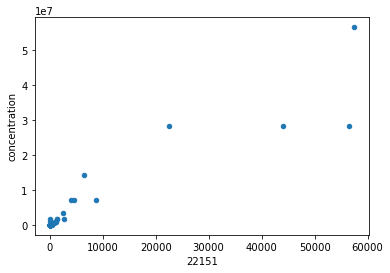

In [35]:
concentrations_kallisto.plot.scatter(x='22151', y='concentration')

In [36]:
numpy.polyfit(concentrations_kallisto['22151'], concentrations_kallisto['concentration'], deg=1)

array([   754.91260841, 314047.90329891])

In [37]:
concentrations_rsem = pandas.merge(
    hff_900_rsem_count['22151'][-97:], 
    spikes, 
    left_index=True, right_index=True,
)
concentrations_rsem

22151  length  gc_percent  concentration
tSpikein_ERCC-00002  48882.0    1061        51.4   2.821875e+07
tSpikein_ERCC-00003   3115.0    1023        32.6   1.763672e+06
tSpikein_ERCC-00004   9216.0     523        34.4   1.410938e+07
tSpikein_ERCC-00009      0.0     984        47.3   1.763672e+06
tSpikein_ERCC-00012      1.0     994        50.9   2.152920e+02
...                      ...     ...         ...            ...
tSpikein_ERCC-00164      1.0    1022        37.1   8.611679e+02
tSpikein_ERCC-00165    152.0     872        50.0   1.102295e+05
tSpikein_ERCC-00168      1.0    1024        34.2   8.611679e+02
tSpikein_ERCC-00170     56.0    1023        33.7   2.755737e+04
tSpikein_ERCC-00171   5834.0     505        47.7   7.054688e+06

[92 rows x 4 columns]

In [38]:
def plot_expression_concentration(merged, experiment_name, quantification_name, spike_name, ax=None):
    if ax is None:
        f= pyplot.figure(figsize=(20,6))
        ax=f.add_subplot(1,1,1)
    #num_cells = spike_table.shape[1]
    ax.set_title(f'{quantification_name} for {experiment_name} shown with concentration for {spike_name}')
    #ax.set_ylabel(f'$log_2 {quantification_name}$')
    ax.set_yscale('log')
    ax.grid('both', alpha=0.5)
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    #ax2.set_ylabel('concentration')

    seaborn.stripplot(x='gene_id', y=quantification_name, data=merged, ax=ax)
    seaborn.pointplot(x='gene_id', y='concentration', color=cm.Set1(2), data=merged, ax=ax2, join=True, markers='+')
    #seaborn.barplot(x='gene_id', y='length', color=cm.Set1(1),data=expression, ax=axes[1])

    for label in ax.get_xticklabels():
        label.set_rotation(90)

    ax2.set_ylabel(ax2.get_ylabel(), color=cm.Set1(2))
    return ax
    
def merge_expression_and_spikes(expression, spikes, quantification_name):
    sorted_spikes = spikes.sort_values('concentration')
    unstack = expression[expression > 0].reindex(sorted_spikes.index).unstack()
    unstack = unstack.reset_index()
    unstack.columns = ['library_id', 'gene_id', quantification_name]
    merged = unstack.merge(sorted_spikes, left_on='gene_id', right_index=True)
    return merged

def plot_combined_median_spikes(expression, experiment_name, quantification_name, spikes, spike_name, ax=None):
    merged = merge_expression_and_spikes(expression, spikes, quantification_name)
    ax = plot_expression_concentration(merged, experiment_name, quantification_name, spike_name, ax=ax)


# HFF 900 RSEM spike counts

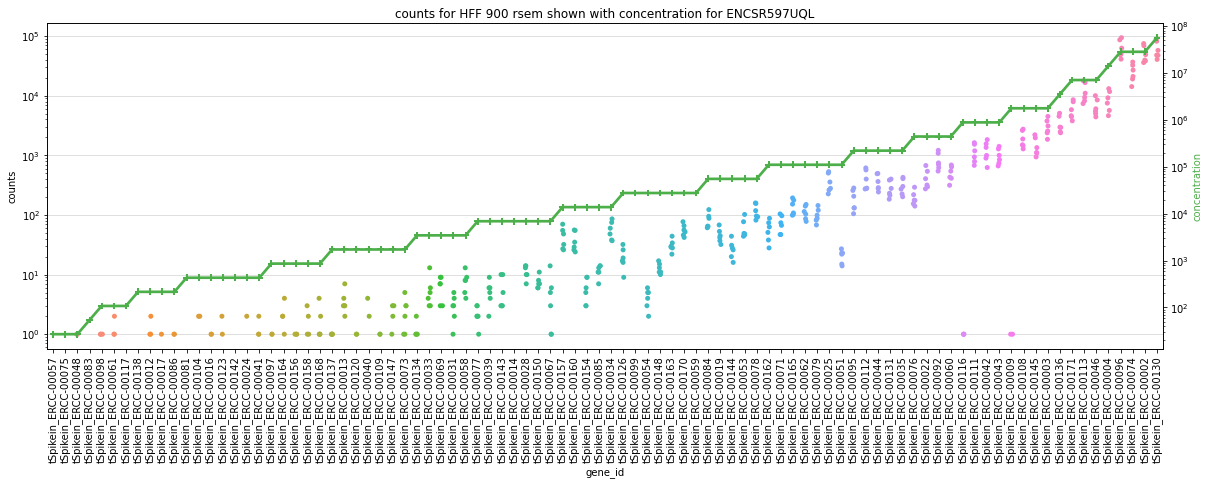

In [39]:
plot_combined_median_spikes(hff_900_rsem_count, 'HFF 900 rsem', 'counts', spikes, 'ENCSR597UQL')

# HFF 900 kallisto spike counts

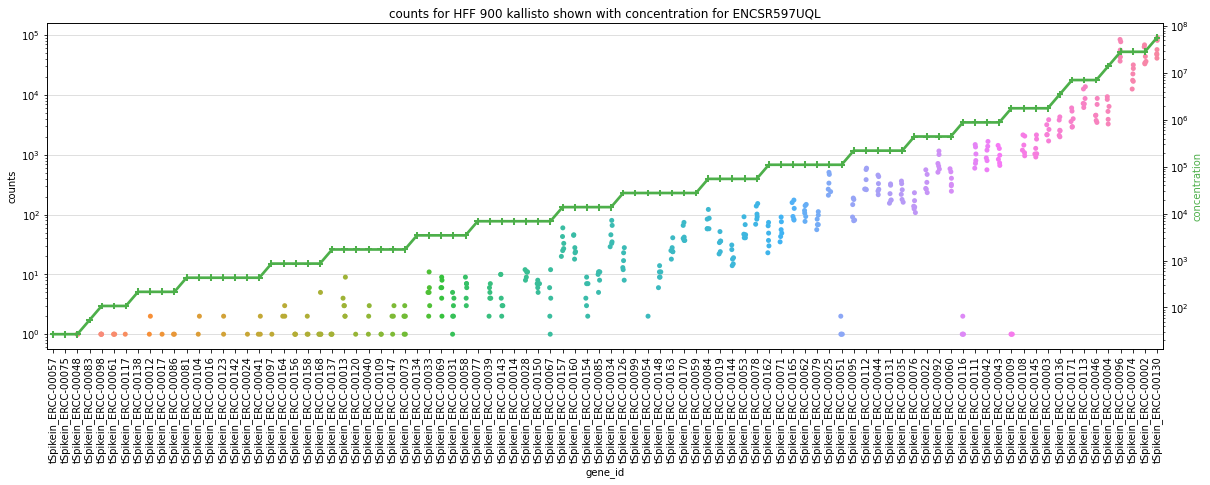

In [40]:
plot_combined_median_spikes(hff_900_kallisto_count, 'HFF 900 kallisto', 'counts', spikes, 'ENCSR597UQL')

# HFF 900 salmon spike counts

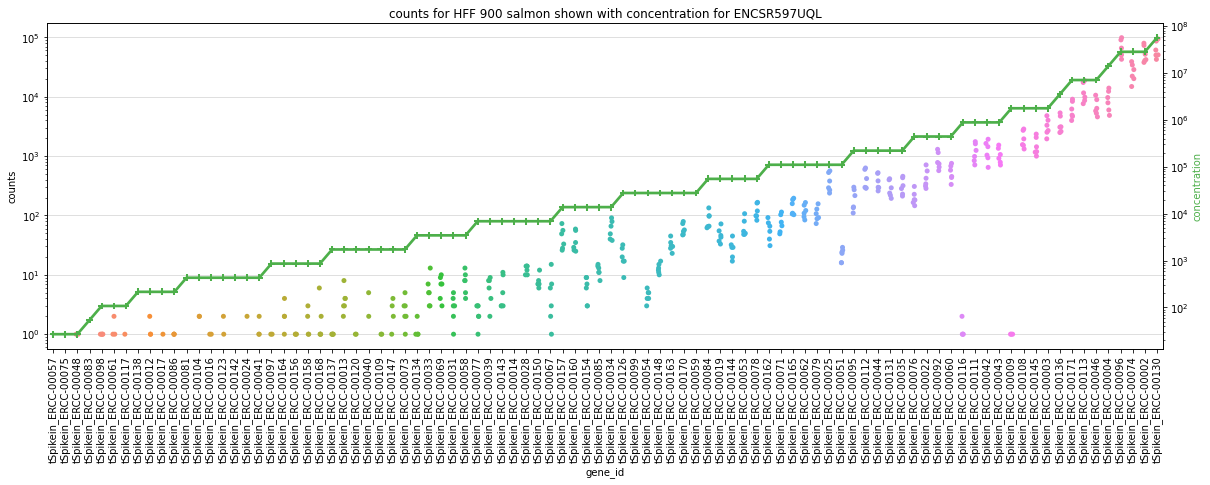

In [41]:
plot_combined_median_spikes(hff_900_salmon_count, 'HFF 900 salmon', 'counts', spikes, 'ENCSR597UQL')

Code to plot all of the HFF experiment spike ladders

In [42]:
def spike_series(experiments, experiment_name, libraries, spikes, quantification, spike_name):
    kallisto_quantification_name = {
        'tpm': 'tpm',
        'count': 'est_counts',
    }
    rsem_quantification_name = {
        'tpm': 'TPM',
        'count': 'expected_count',
    }
    salmon_quantification_name = {
        'tpm': 'TPM',
        'count': 'NumReads',
    }    
    
    kallisto = load_kallisto_replicates(
        experiments.loc[experiment_name],
        libraries,
        column=kallisto_quantification_name[quantification],
    )
    rsem = madqc.load_transcriptome_quantifications(    
        experiments.loc[experiment_name],
        libraries,
        column=rsem_quantification_name[quantification]
    )
    salmon = load_salmon_replicates(    
        experiments.loc[experiment_name],
        libraries,
        column=salmon_quantification_name[quantification]
    )

    kallisto_merged = merge_expression_and_spikes(kallisto, spikes, quantification)
    rsem_merged = merge_expression_and_spikes(rsem, spikes, quantification)
    salmon_merged = merge_expression_and_spikes(salmon, spikes, quantification)
    
    f = pyplot.figure(figsize=(20,12))
    f.suptitle("{} {}".format(experiment_name, quantification), fontsize=12)
    axes = f.subplots(4, 1, sharex=True)
    #plot_combined_median_spikes(kallisto, "kallisto " + experiment_name, quantification, spikes['concentration'], 'ENCSR597UQL', ax=ax)
    plot_expression_concentration(kallisto_merged, "Kallisto " + experiment_name, quantification, spike_name, ax=axes[0])
    #plot_combined_median_spikes(rsem, "rsem " + experiment_name, quantification, spikes['concentration'], 'ENCSR597UQL', ax=ax)
    plot_expression_concentration(rsem_merged, "RSEM " + experiment_name, quantification, spike_name, ax=axes[1])
    #plot_combined_median_spikes(salmon, "salmon " + experiment_name, quantification, spikes['concentration'], 'ENCSR597UQL', ax=ax)        
    plot_expression_concentration(salmon_merged, "Salmon " + experiment_name, quantification, spike_name, ax=axes[2])
    seaborn.barplot(x='gene_id', y='length', data=kallisto_merged, ax=axes[3])
    
    for label in axes[3].get_xticklabels():
        label.set_rotation(90)
    

In [43]:
def all_spike_series(experiments, libraries, spikes, spike_name):
    for experiment_name in experiments.index:
        for quantification in ['tpm', 'count']:
            spike_series(experiments, experiment_name, libraries, spikes, quantification, spike_name)

# All HFF experiment spike detections for counts and TPMs

The following plots of all of the HFF experiments show two sets of four panels for each experiment. One set is for counts the other TPMs. In the four panels the first three show the detected spike in quantifications on the left axis, and the expected spike in concentration on the right for each algorithm. The fourth panel shows the length of the ERCC spike in transcript.

The different values for the same spike represent the different libraries in the experiment. Zero values were  filtered out and do not show up. The spike ins were sorted by the listed concentration value, and the same order was then applied to the algorithm quantification values.

I didn't calculate the relationship between known concentrations and detected quantification so it doesn't mean anything if the quantification ladder is consistently offset from the known concentrations. What does matter is if one set of spikes behave differently between the different algorithm.

What I've noticed so far is that ERCC-00134 (in light green), ERCC-000054 (cyan), and ERCC-000051 (end of blue) are lower or missing in kallisto. Salmon tends to match or be a bit higher than RSEM's values. These are the shortest of the ERCC spike transcripts (~ 275bp) and are about the same size as the provided average fragment length (~233 bp) given to Kallisto.

The source data is a a protocol test by Brian going through the HFFs at different concentrations.



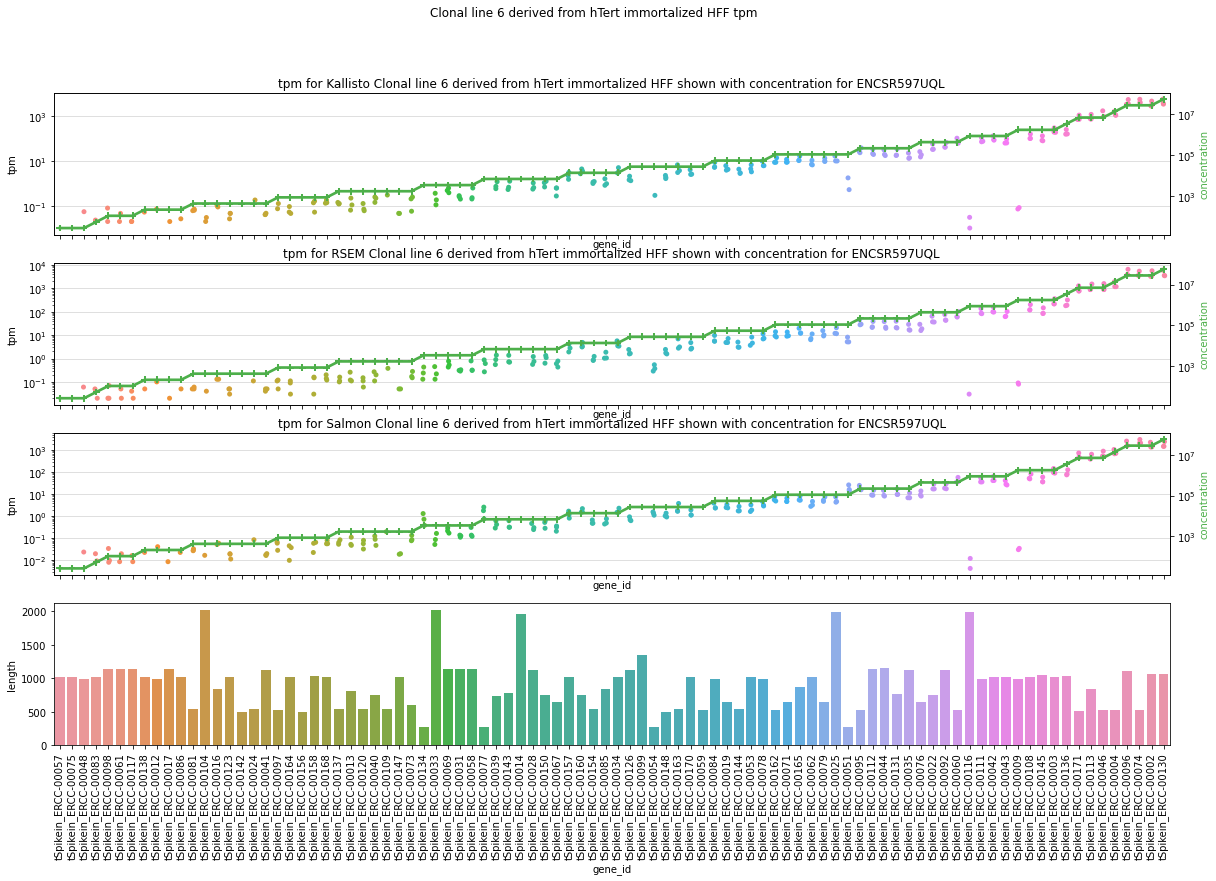

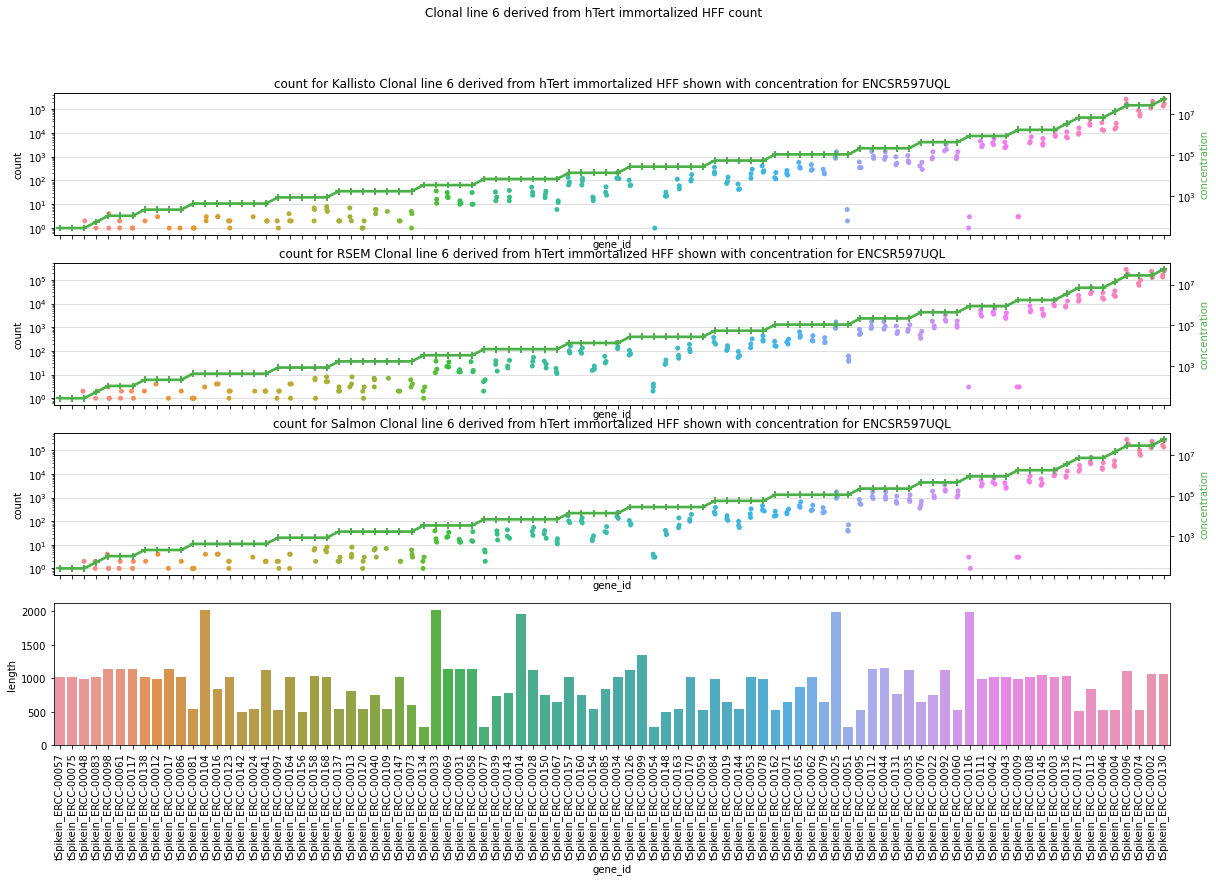

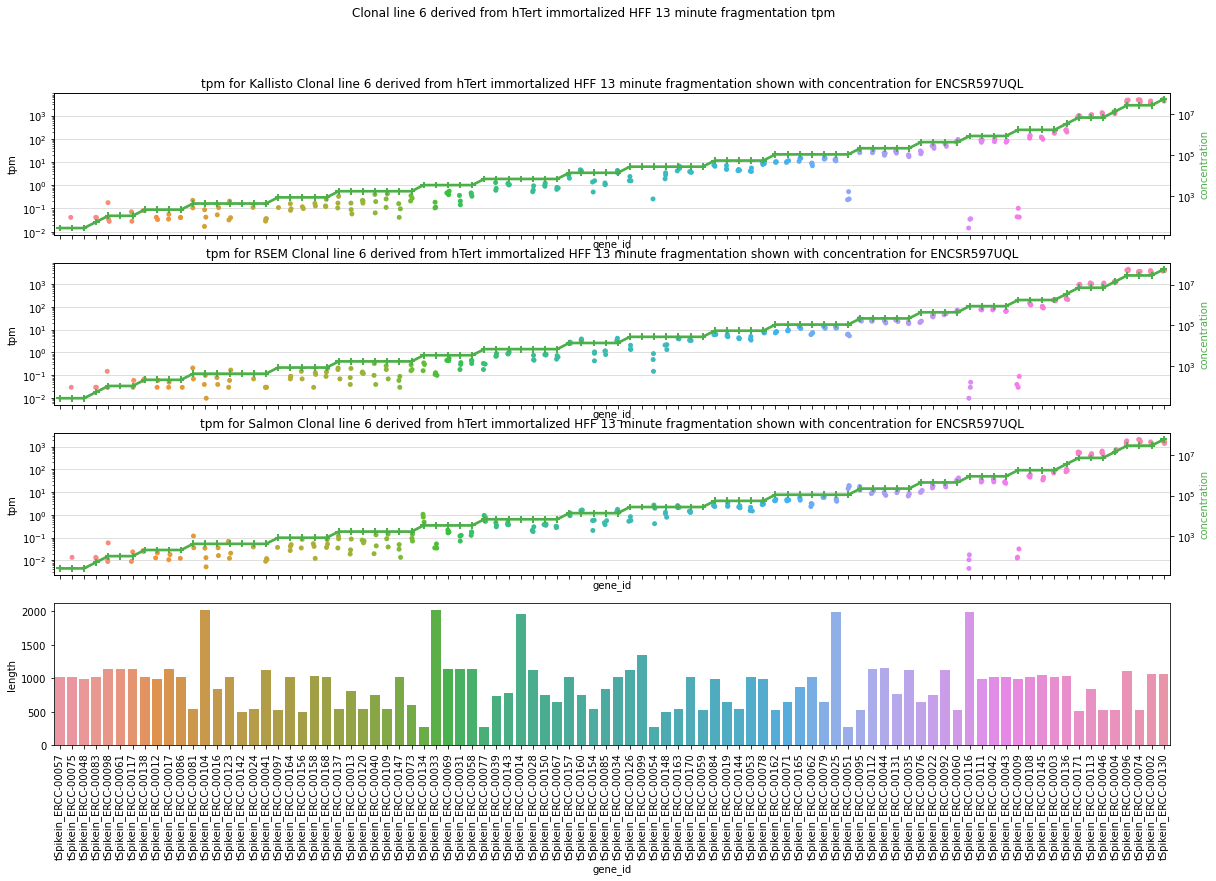

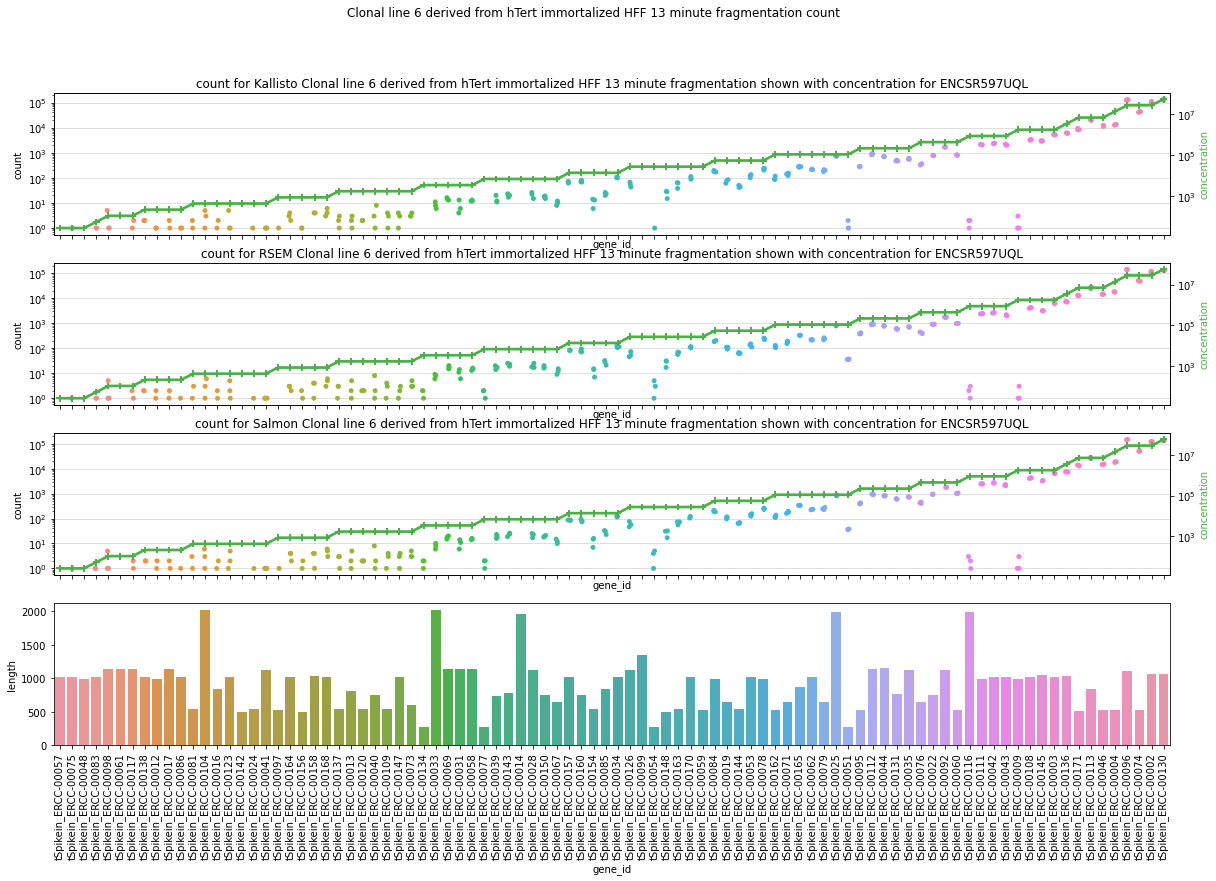

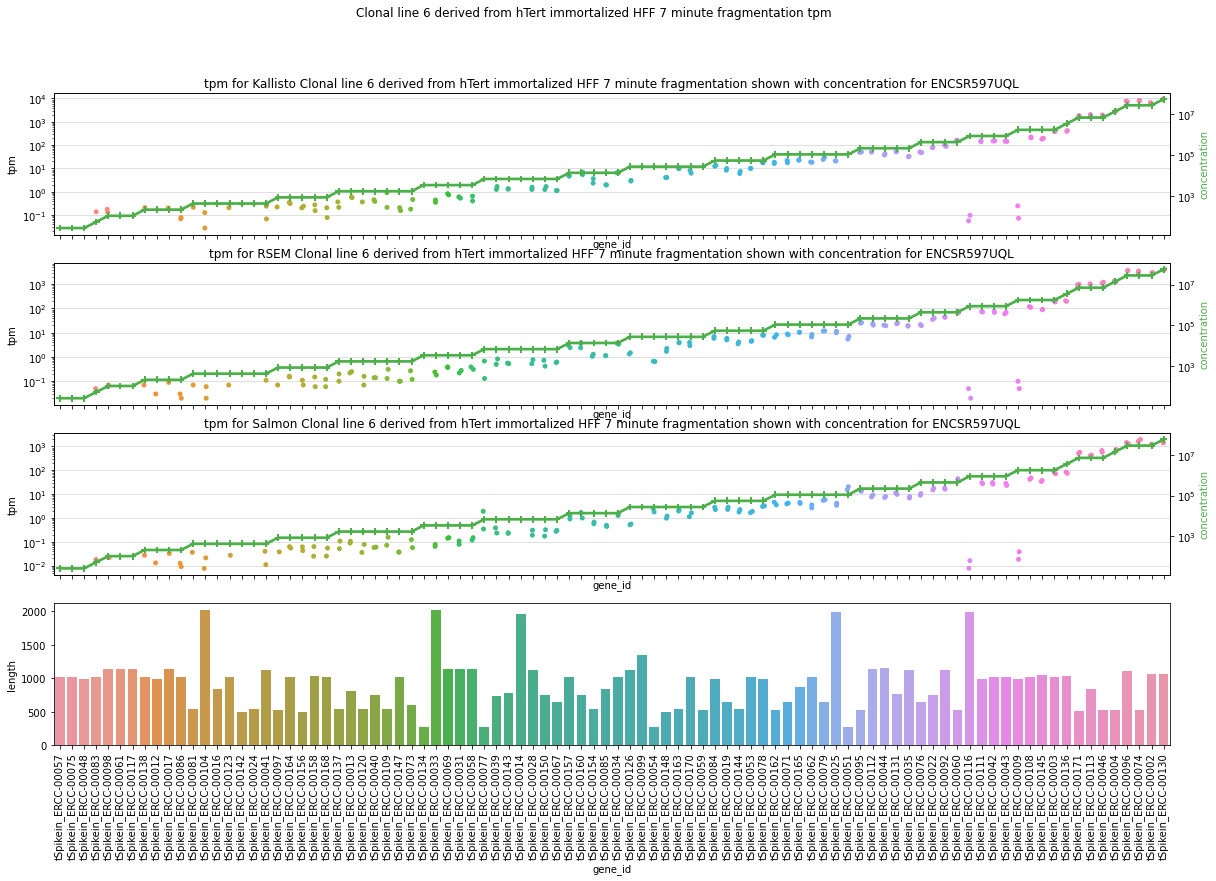

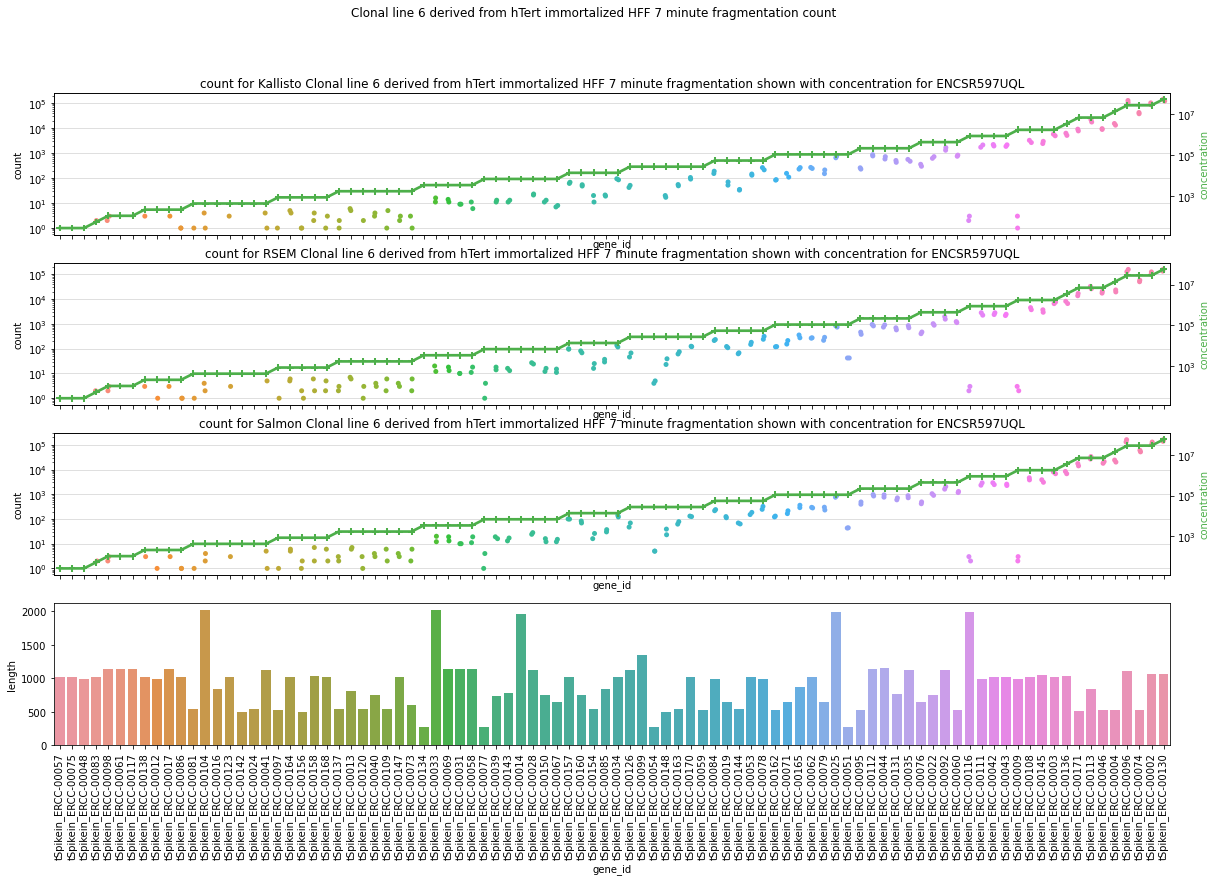

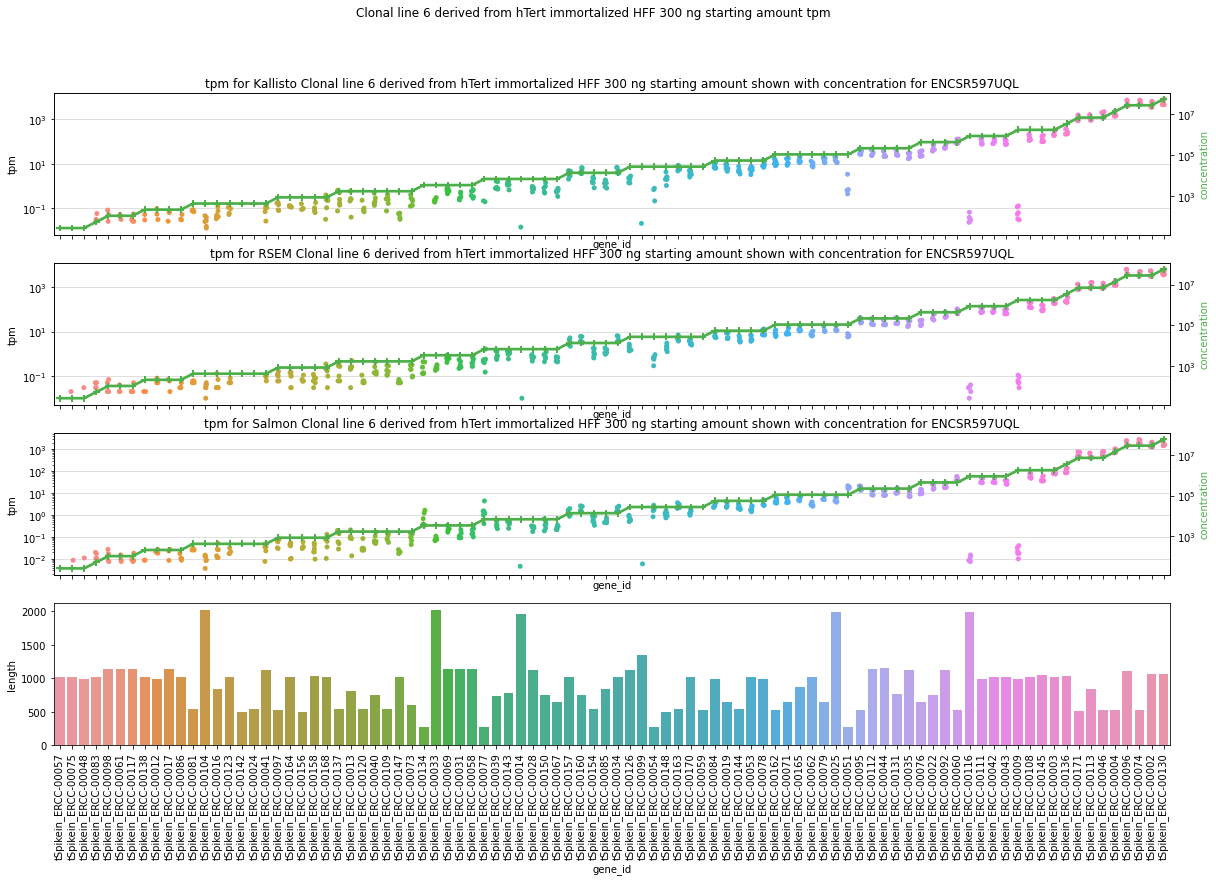

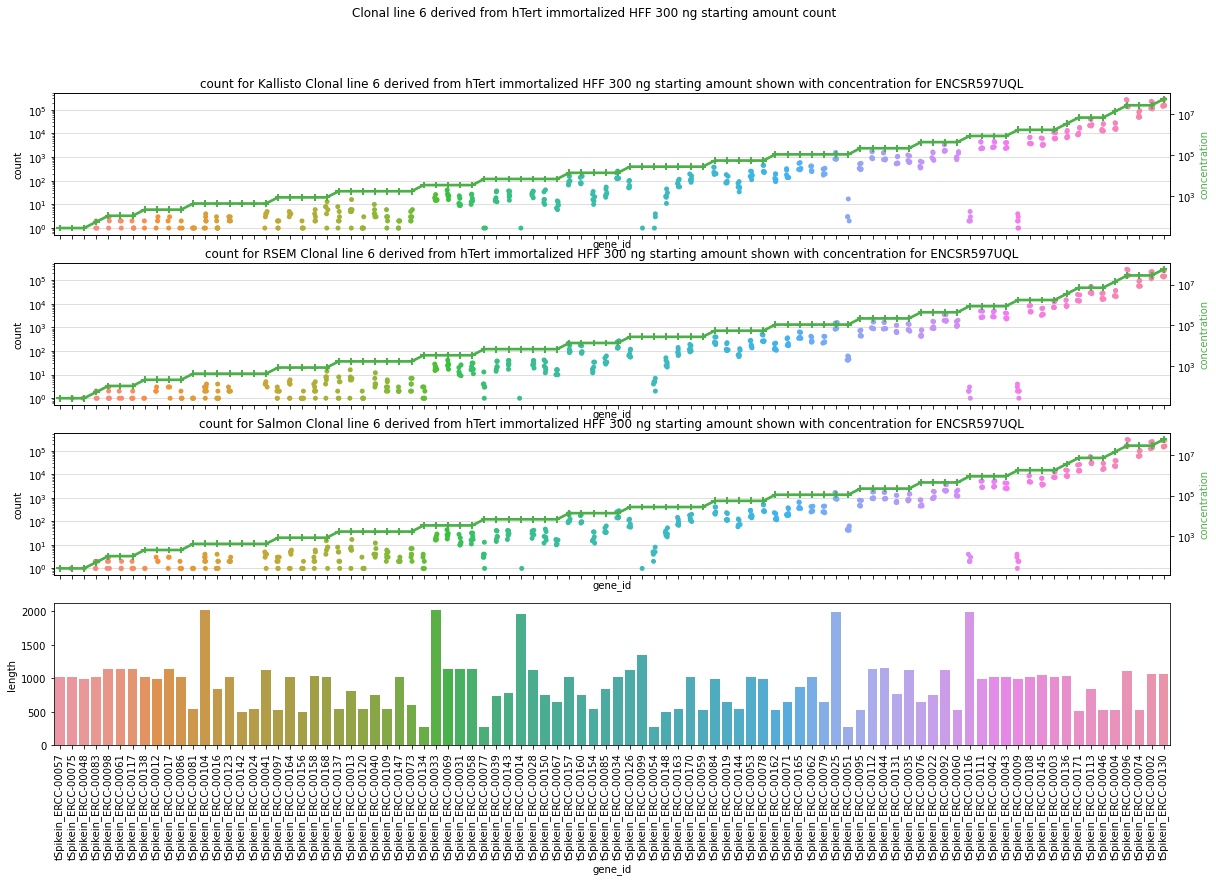

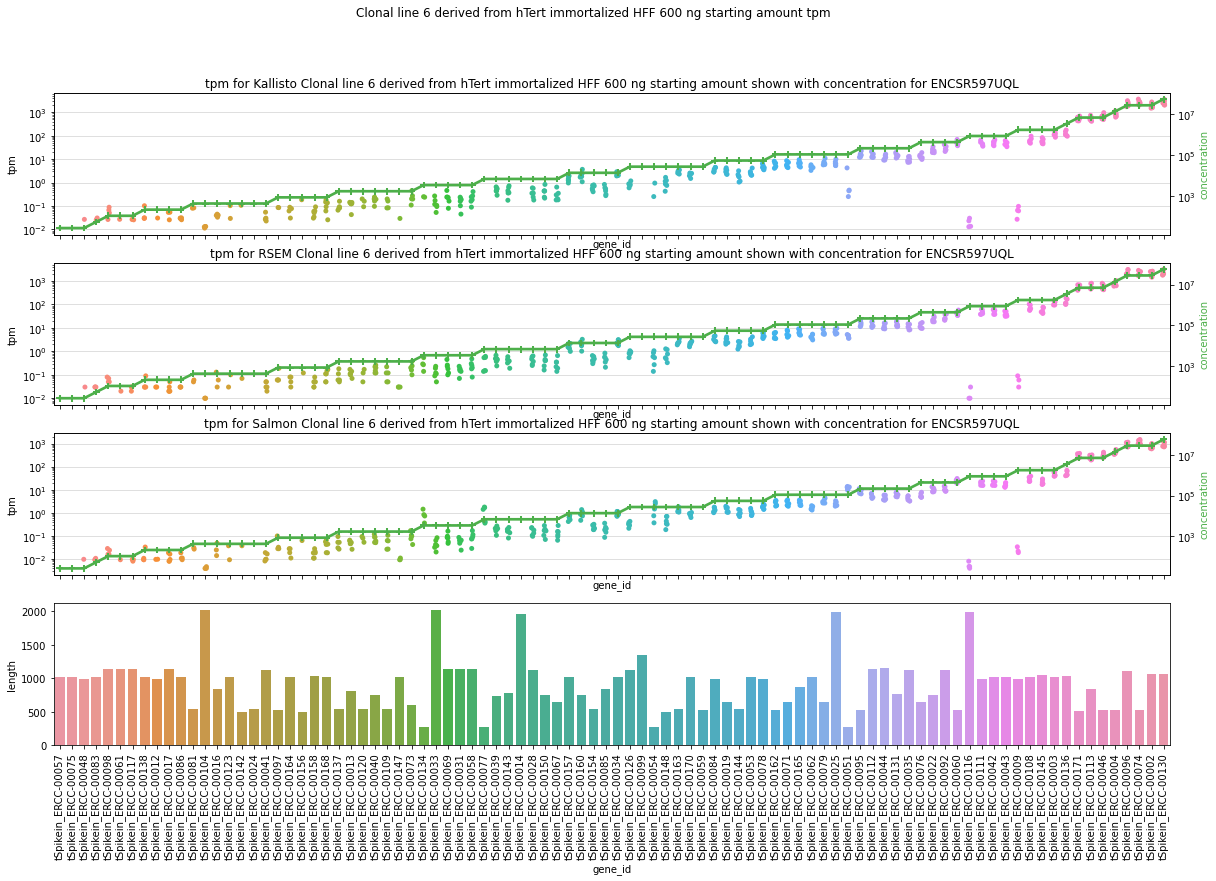

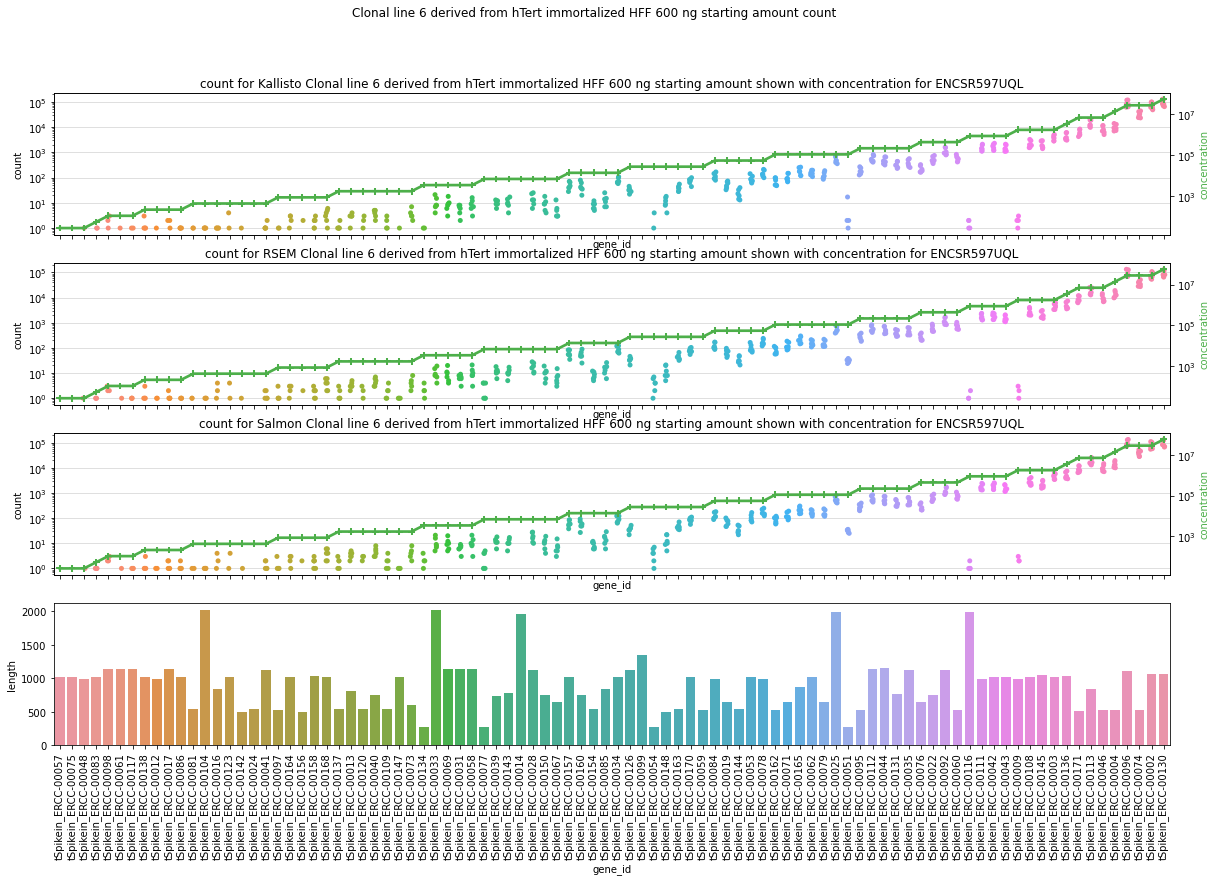

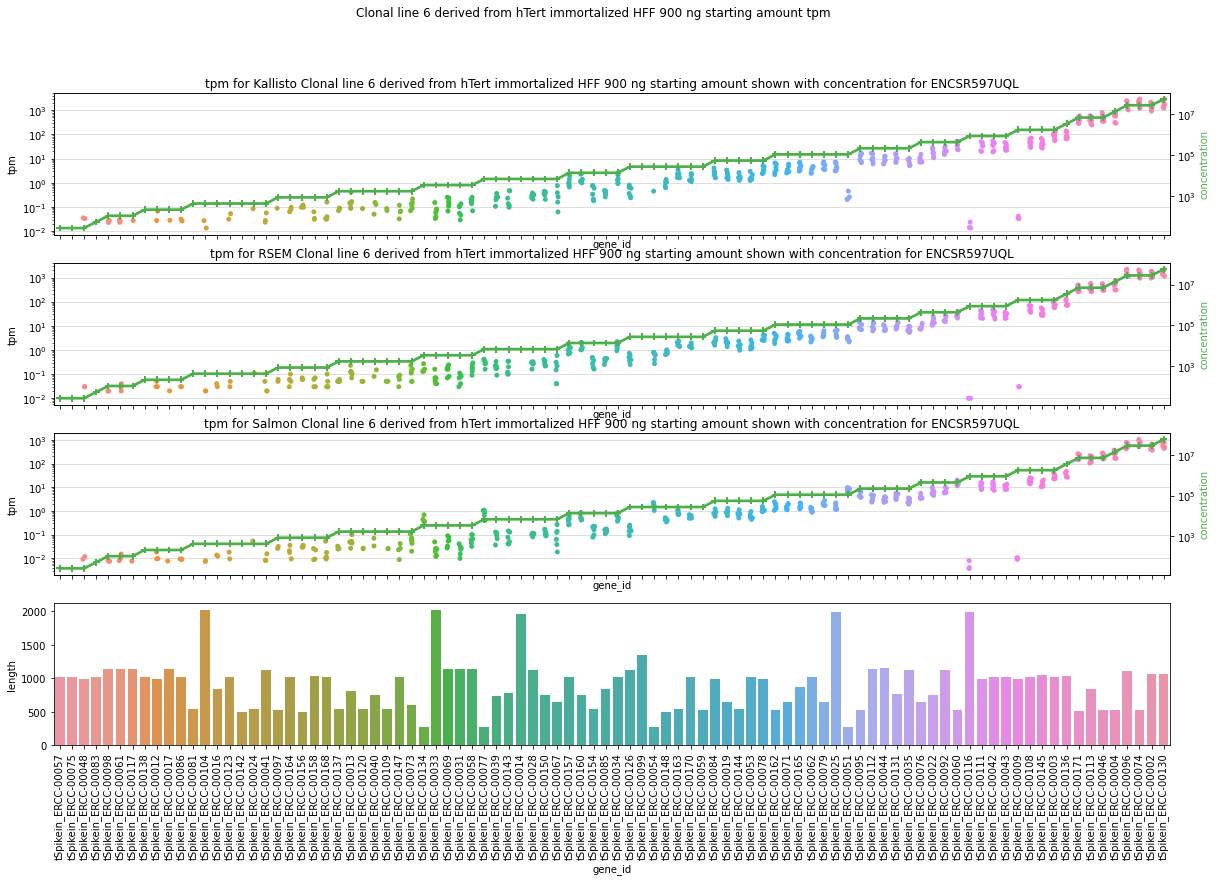

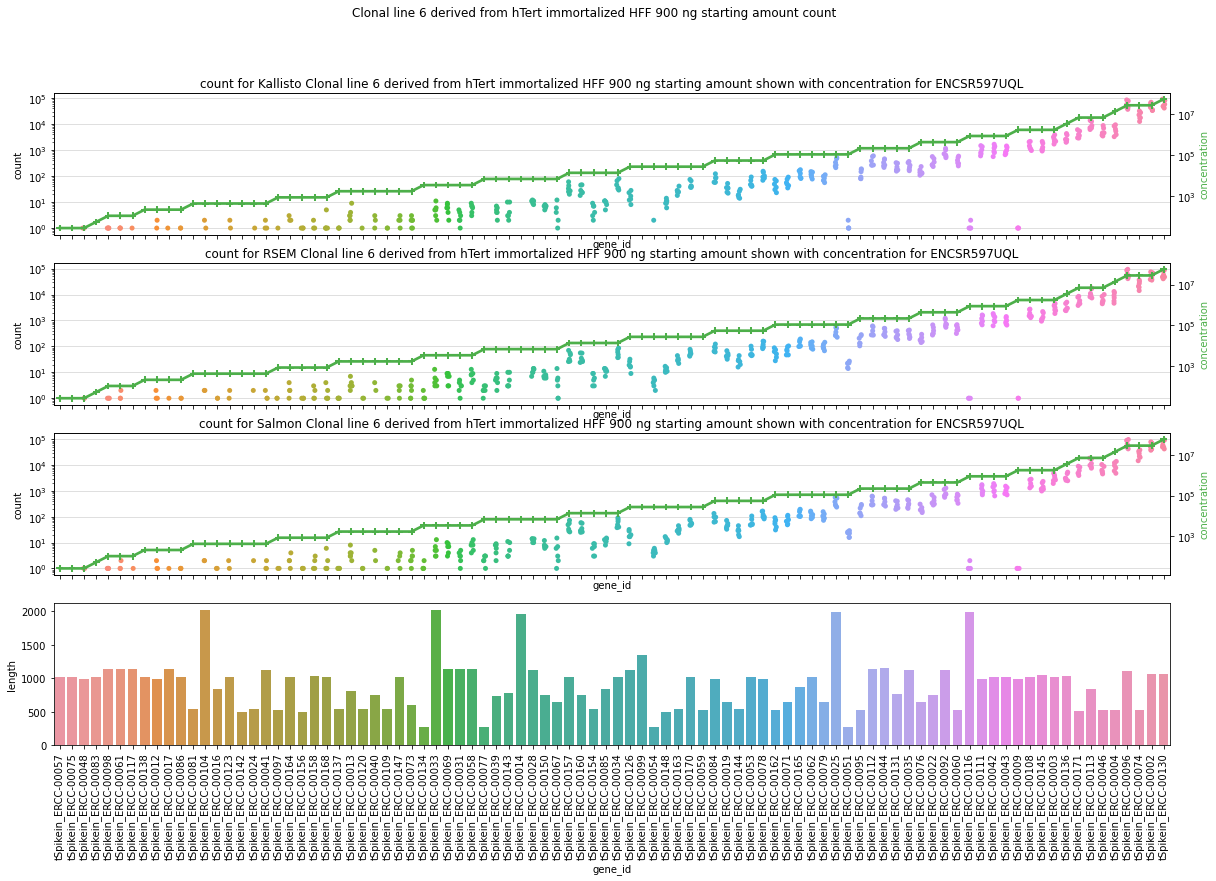

In [44]:
_ = all_spike_series(experiments, libraries, spikes, 'ENCSR597UQL')